In [66]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import os

Let's import the dataset and check for any nan values or class imbalance.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB
not.fully.paid
0    0.839946
1    0.160054
Name: proportion, dt

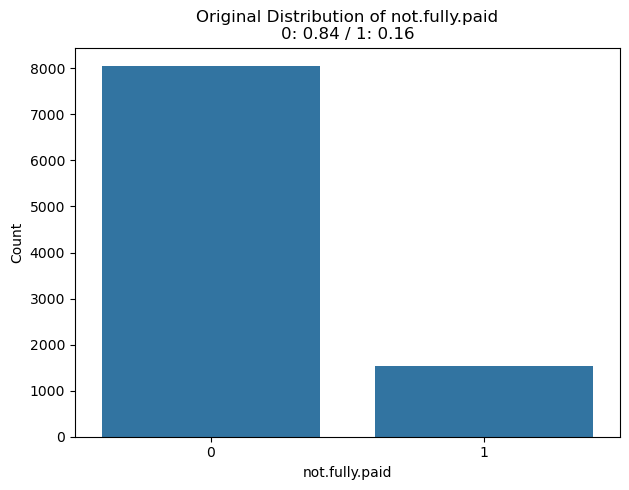

In [64]:
# Load the loan data
file_path = "loan_data.xls"
loan_data = pd.read_csv(file_path)

# Get information about the loan data
loan_data_info = loan_data.info()

# Calculate and print the target distribution
target_distribution = loan_data['not.fully.paid'].value_counts(normalize=True)
print(target_distribution)

# Split features and target variable
X = loan_data.drop('not.fully.paid', axis=1)
y = loan_data['not.fully.paid']

# Convert categorical features to numerical using one-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Plot the original distribution of the target variable
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y)
distribution_text = " / ".join([f"{index}: {value:.2f}" for index, value in target_distribution.items()])
plt.title(f'Original Distribution of not.fully.paid\n{distribution_text}')
plt.xlabel('not.fully.paid')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


The dataset contains information about loans issued through the LendingClub platform. Below are the descriptions of each column in the dataset:

1. **credit.policy**:
   - **Description**: Indicates if the customer meets the credit underwriting criteria of LendingClub.com.
   - **Values**: 
     - `1`: Meets the criteria
     - `0`: Does not meet the criteria

2. **purpose**:
   - **Description**: The purpose of the loan.
   - **Values**: 
     - `credit_card`
     - `debt_consolidation`
     - `educational`
     - `major_purchase`
     - `small_business`
     - `all_other`

3. **int.rate**:
   - **Description**: The interest rate of the loan as a proportion (e.g., a rate of 11% is stored as 0.11). Riskier borrowers are assigned higher interest rates.

4. **installment**:
   - **Description**: The monthly installment owed by the borrower if the loan is funded.

5. **log.annual.inc**:
   - **Description**: The natural logarithm of the borrower's self-reported annual income.

6. **dti**:
   - **Description**: The debt-to-income ratio of the borrower (amount of debt divided by annual income).

7. **fico**:
   - **Description**: The FICO credit score of the borrower.

8. **days.with.cr.line**:
   - **Description**: The number of days the borrower has had a credit line.

9. **revol.bal**:
   - **Description**: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).

10. **revol.util**:
    - **Description**: The borrower's revolving line utilization rate (amount of credit line used relative to total credit available).

11. **inq.last.6mths**:
    - **Description**: The number of inquiries by creditors in the last 6 months.

12. **delinq.2yrs**:
    - **Description**: The number of times the borrower has been 30+ days past due on a payment in the past 2 years.

13. **pub.rec**:
    - **Description**: The number of derogatory public records of the borrower (e.g., bankruptcy filings, tax liens, judgments).


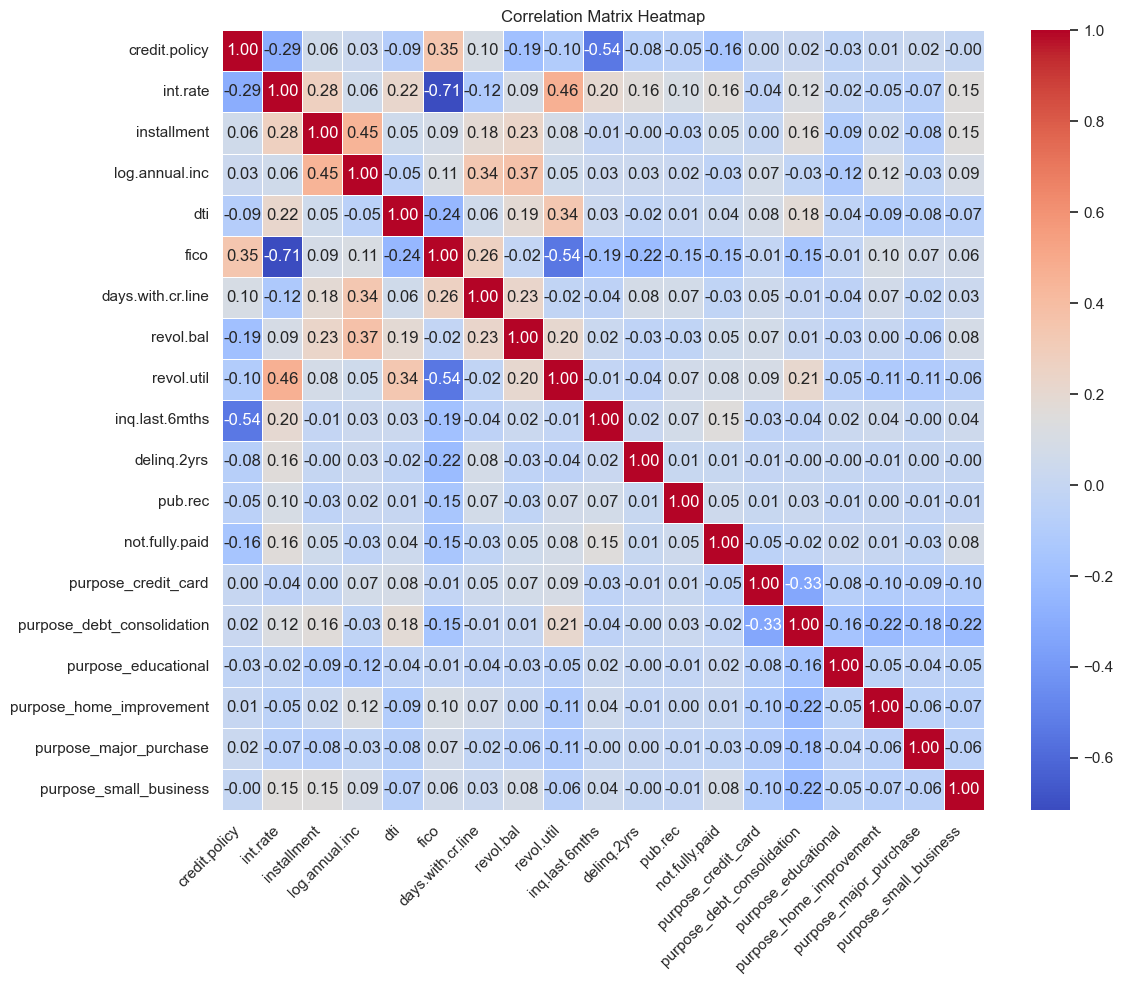

In [98]:
# Convert categorical features to numerical using one-hot encoding
loan_data_encoded = pd.get_dummies(loan_data, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = loan_data_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

# Add titles and labels
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


Given that approximately 84% of the people fully paid their loan back and 16% did not. It is safe to say that the dataset is highly skewed. We're going to address this issue after splitting the data into 4 sets that have similar distrubtions, for simulating a real dataflow. 

In [92]:
# Combine features and target for splitting
loan_data_encoded = X_encoded.copy()
loan_data_encoded['not.fully.paid'] = y

# Split the data into 4 batches with similar distribution
batches = []
remaining_data = loan_data_encoded

for i in range(3):
    batch, remaining_data = train_test_split(remaining_data, test_size=(3 - i) / (4 - i), stratify=remaining_data['not.fully.paid'])
    batches.append(batch)

# Add the last remaining batch
batches.append(remaining_data)

# Save each batch to a CSV file
for i, batch in enumerate(batches):
    batch.to_csv(f'batches/batch_{i + 1}.csv', index=False)

# Verify the distribution of each batch
for i, batch in enumerate(batches):
    print(f'Distribution in batch_{i + 1}.csv:')
    print(batch['not.fully.paid'].value_counts(normalize=True))


Distribution in batch_1.csv:
not.fully.paid
0    0.840017
1    0.159983
Name: proportion, dtype: float64
Distribution in batch_2.csv:
not.fully.paid
0    0.840017
1    0.159983
Name: proportion, dtype: float64
Distribution in batch_3.csv:
not.fully.paid
0    0.839666
1    0.160334
Name: proportion, dtype: float64
Distribution in batch_4.csv:
not.fully.paid
0    0.840084
1    0.159916
Name: proportion, dtype: float64


Now that the split is complete, we can address the class imbalance by oversampling the minority class in each batch. This is to prevent information leakage.

In [68]:
# Folder containing the CSV files
folder_path = 'batches/'

# Iterate over each CSV file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)
        
        # Load the data
        df = pd.read_csv(file_path)
        
        # Assume the last column is the target variable
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        
        # Apply SMOTE
        smote = SMOTE()
        X_resampled, y_resampled = smote.fit_resample(X, y)
        
        # Combine the resampled data into a DataFrame
        df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=[df.columns[-1]])], axis=1)
        
        # Create the new file name with 'R' before the file extension
        resampled_file_name = file_name.replace('.csv', 'R.csv')
        resampled_file_path = os.path.join(folder_path, resampled_file_name)
        
        # Save the resampled data to a new CSV file
        df_resampled.to_csv(resampled_file_path, index=False)
        
        print(f"Resampled data saved to {resampled_file_path}")

Resampled data saved to batches/batch_1R.csv
Resampled data saved to batches/batch_2R.csv
Resampled data saved to batches/batch_3R.csv
Resampled data saved to batches/batch_4R.csv


Let's check the class balance of all batches.

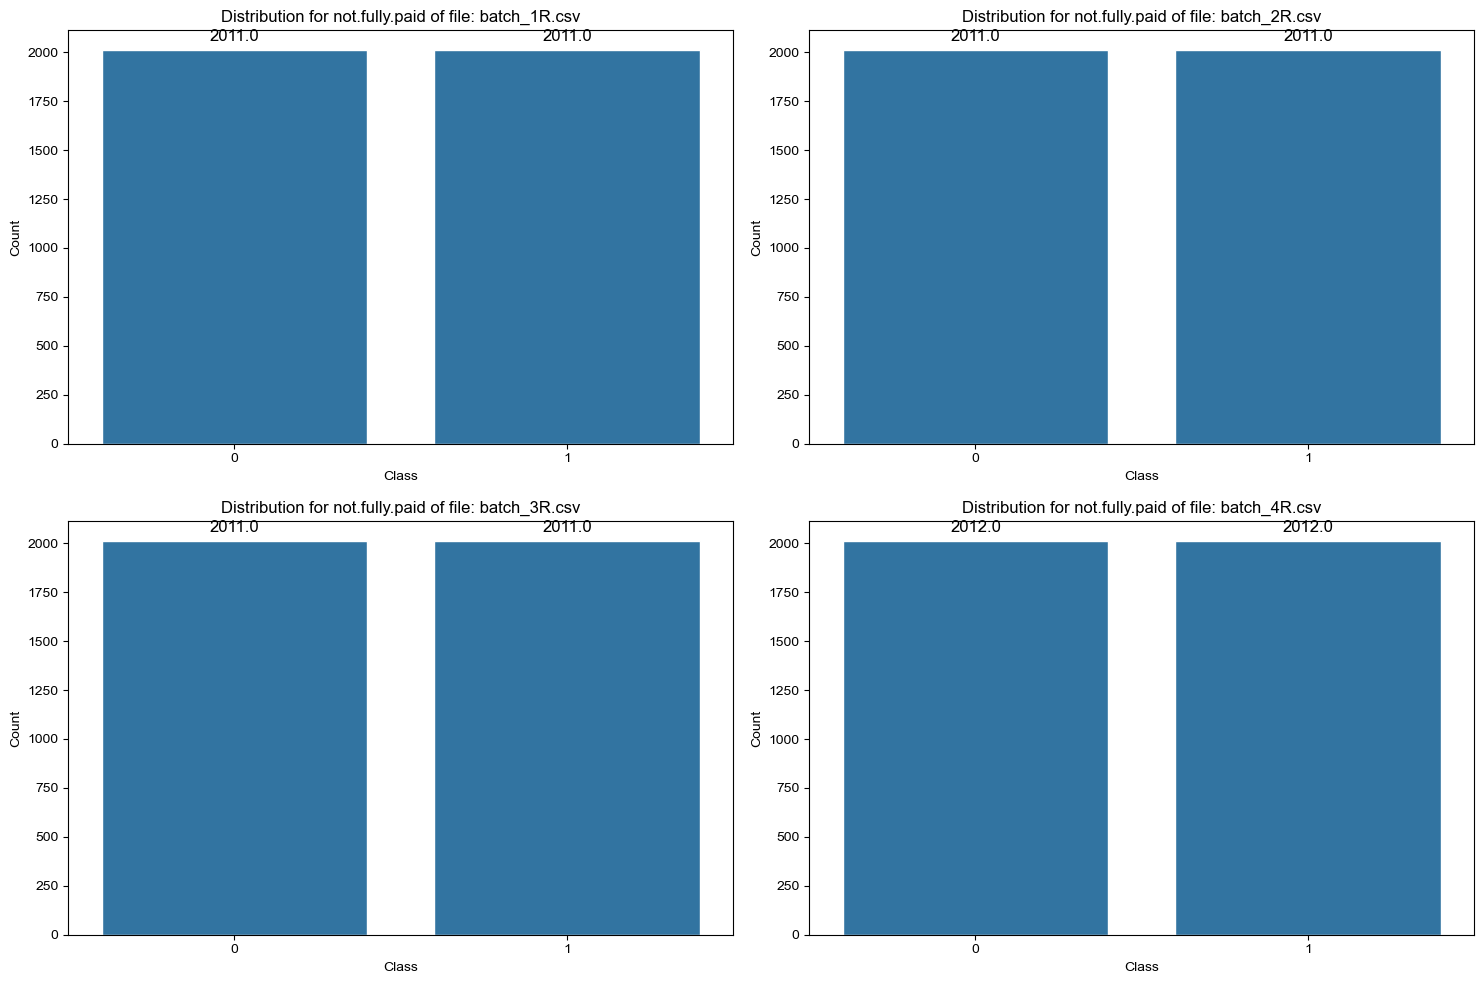

In [95]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Folder containing the CSV files
folder_path = 'batches/'

# Collect the resampled file names
resampled_files = [file for file in os.listdir(folder_path) if file.endswith('R.csv')]

# Set up the subplot grid
num_files = len(resampled_files)
num_cols = 2  # Number of columns for the subplot grid
num_rows = (num_files + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()

# Apply a different theme
sns.set_theme(style="whitegrid")

# Iterate over each resampled CSV file
for idx, file_name in enumerate(resampled_files):
    # Construct the full file path
    file_path = os.path.join(folder_path, file_name)
    
    # Load the data
    df = pd.read_csv(file_path)
    
    # Assume the last column is the target variable
    target = df.iloc[:, -1]
    
    # Plot the distribution of the target variable
    ax = sns.countplot(x=target, ax=axes[idx])
    axes[idx].set_title(f'Distribution for not.fully.paid of file: {file_name}')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Count')

    # Add text annotations to show the count of each class
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                    textcoords='offset points')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


Now that all four of our batches have a 50/50 distribution for the target variable, let's examine the distributions for every other column in these batches.

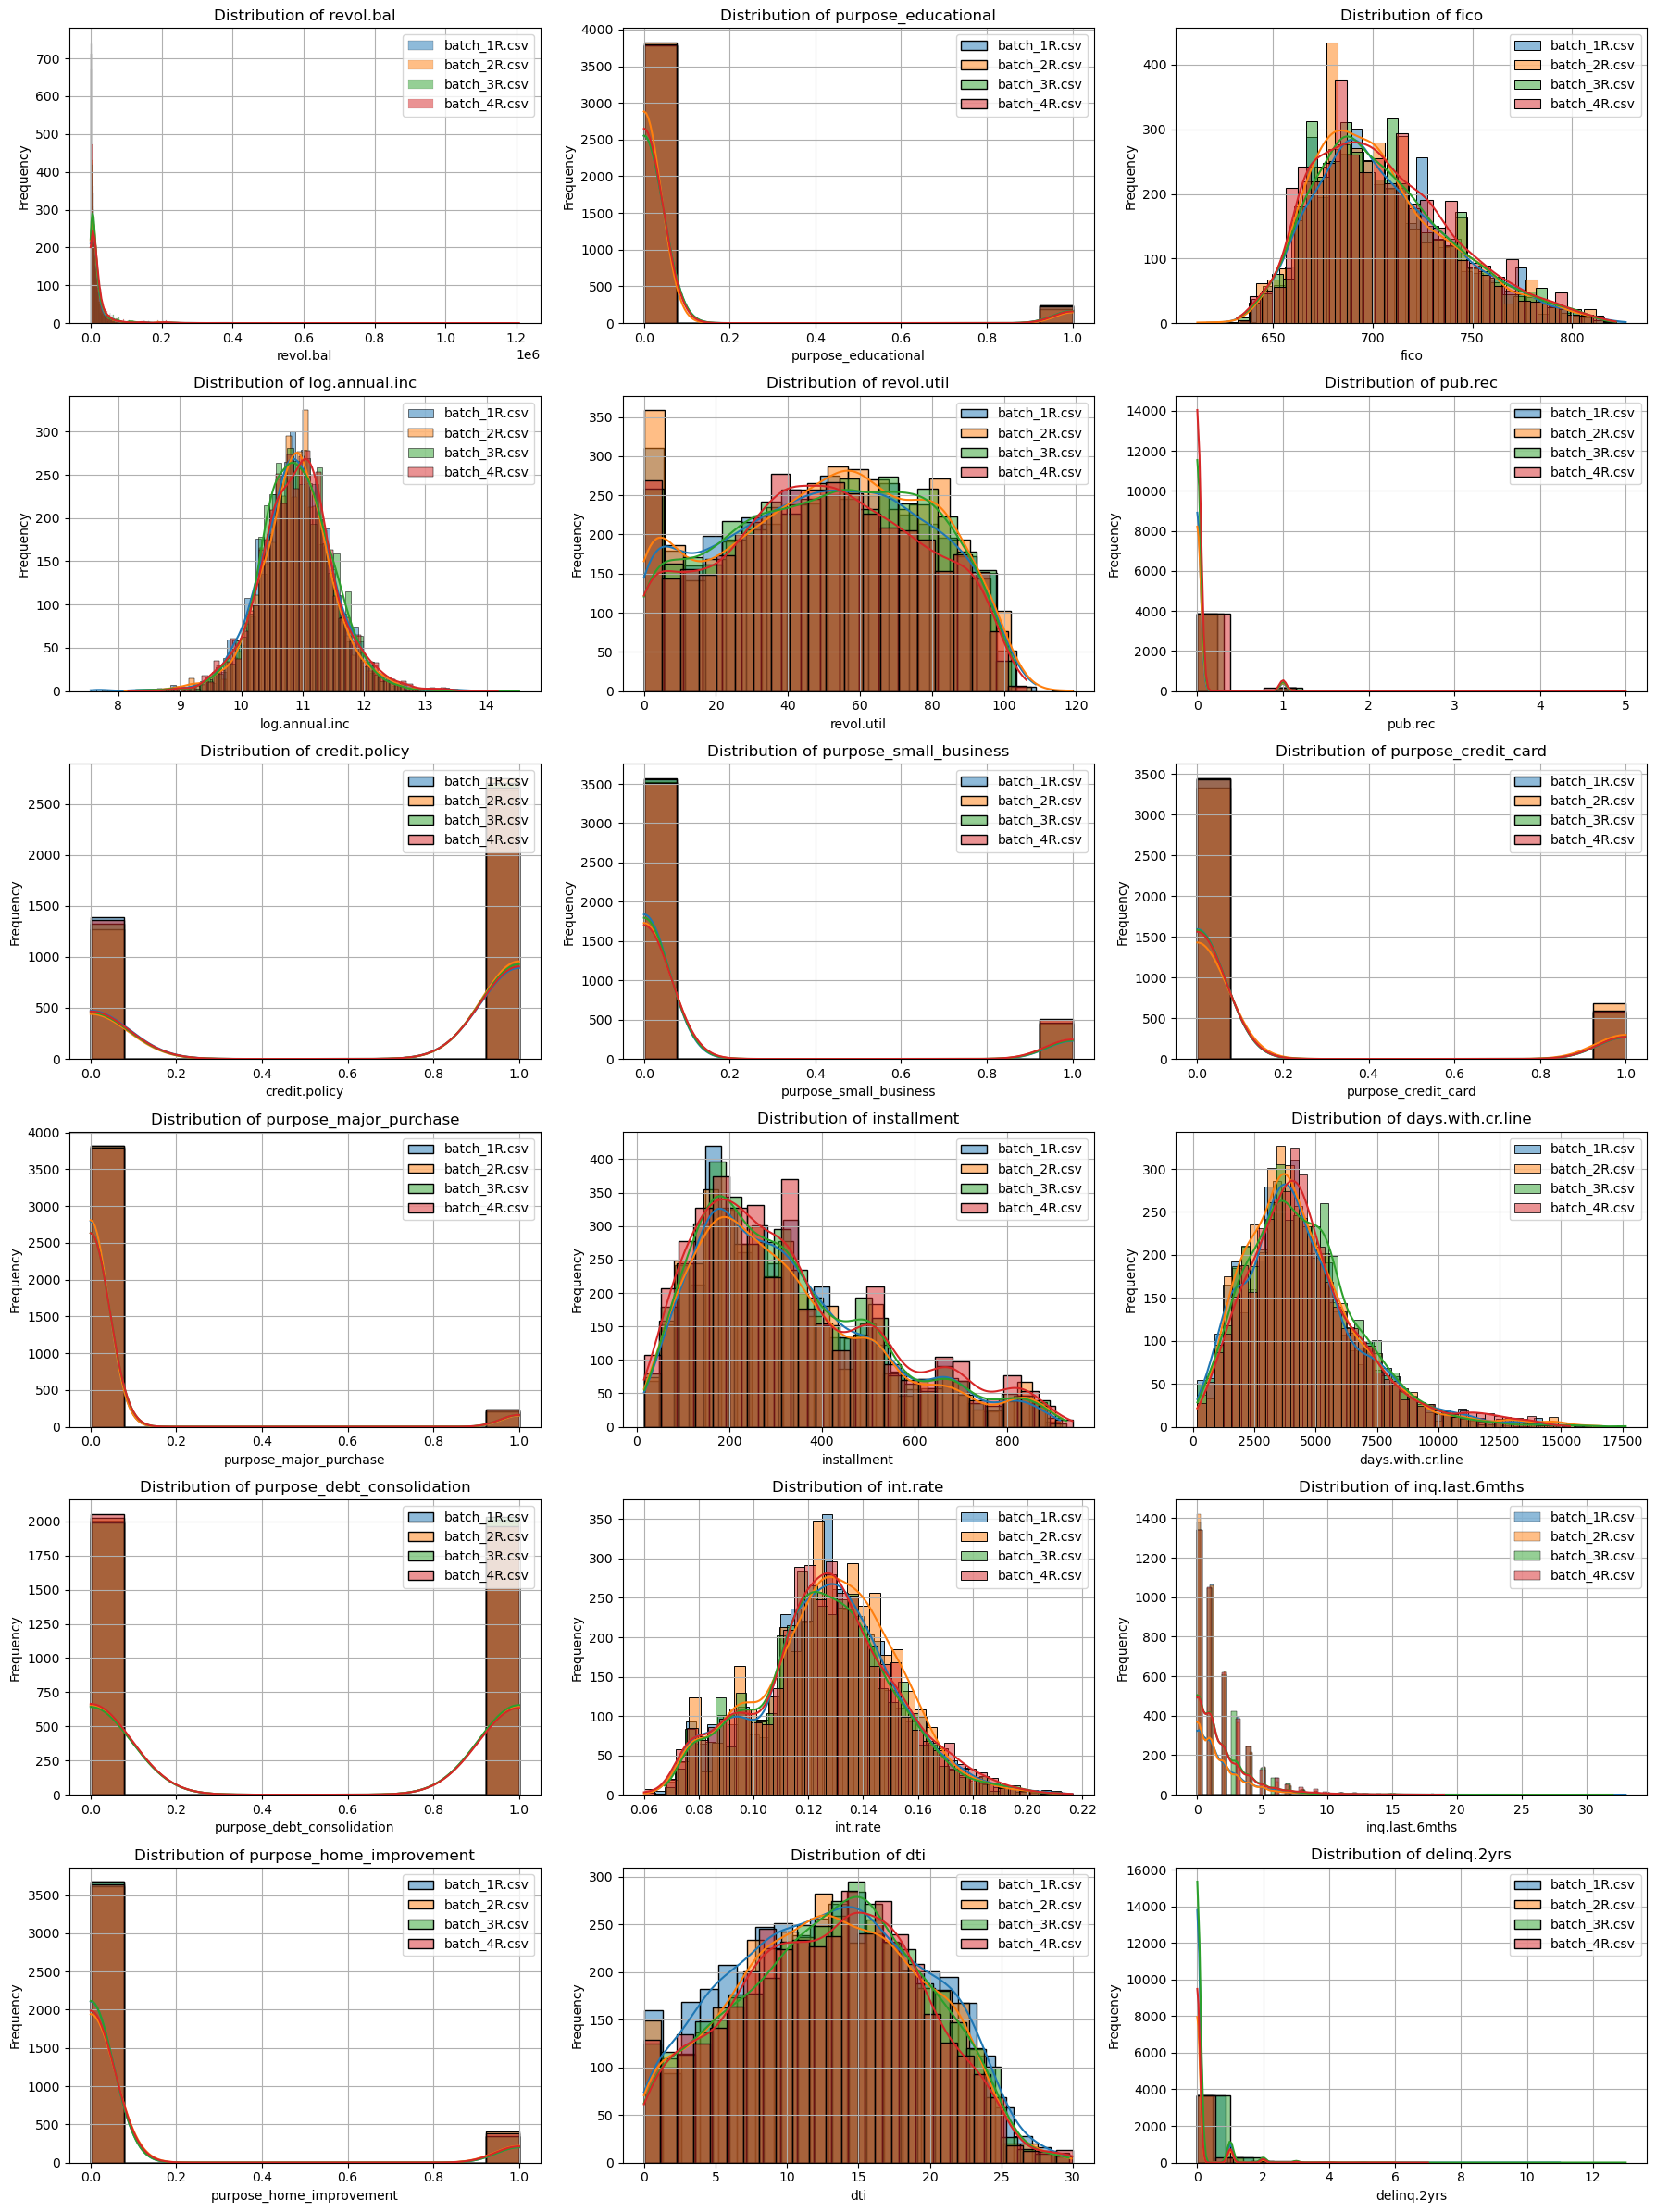

In [94]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directory containing the CSV files
directory = 'batches/'  # Replace with your directory path

# Initialize a dictionary to store dataframes for each file
dataframes = {}

# List all files in the directory
for file_name in os.listdir(directory):
    # Check if the file name ends with 'R.csv'
    if file_name.endswith('R.csv'):
        # Construct full file path
        file_path = os.path.join(directory, file_name)
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        dataframes[file_name] = df

# Get all unique columns from all dataframes
all_columns = set()
for df in dataframes.values():
    all_columns.update(df.columns)

# Define a list of new colors for the histograms
colors = sns.color_palette()

# Create a subplot for each column, excluding "not fully paid" since we already know it
all_columns.discard("not.fully.paid")
n_cols = 3
n_rows = (len(all_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 6, n_rows * 4))

for i, column in enumerate(all_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    for (file_name, df), color in zip(dataframes.items(), colors):
        if column in df.columns:
            sns.histplot(df[column], kde=True, label=file_name, color=color, alpha=0.5)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.grid(True)

plt.tight_layout()
plt.show()
